This notebook has the code for:
1) Making a table with the corresponding gene name for each transcript from wormbase
2) Making a table with just one entry per gene, with locations corresponding to the longest transcript
3) Identifying the chromatin domain which each gene is in for the early embryo and third instar larva.
4) Analysing the numbers of genes in each domain at different cutoffs for how much of the gene must overlap with the chromatin domain.
5) Extracting all the genes that change from one domain to another between early embryos and L3 for the 100% cutoff. 

Had already made a table with just one entry per gene, with locations corresponding to the longest transcript using this notebook: /home/helena_hatrick/part_ii_project/canonical_genesets/elegans_get_good_gene_df. Saved the table to: canonical_genesets/elegans_one_of_each_gene.bed.

# Imports and setup

In [2]:
import pandas as pd
import numpy as np
import pybedtools

In [3]:
from collections import defaultdict

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
chrom_bed_columns=['chrom','chromStart','chromEnd','name',
       'score','strand','thickStart','thickEnd','itemRgb']
bed_12_columns=['chrom','chromStart','chromEnd','name',
       'score','strand','thickStart','thickEnd','itemRgb',
        'blockCount', 'blockSizes', 'blockStart']

In [ ]:
ee_cds=pd.read_csv('chromatin_domains/ee_domains_final.bed', names=chrom_bed_columns, sep='\t')
l3_cds=pd.read_csv('chromatin_domains/l3_domains_final.bed', names=chrom_bed_columns, sep='\t')

df=pd.read_csv('canonical_genesets/elegans_one_of_each_gene.bed', names=bed_12_columns, sep='\t')

# Use bedtools in Ubuntu to get a file of the intersection of chromatin domains and genes in c elegans

a is what you're interested in. b is like the reference. So do a=genes and b=chromatin domains. Will have genes that span more than one entry, potentially even 3 domains. If you have a gene that lies mostly in an active domain but with a couple of base pairs to a border,  you should classify it as active, not as both. You need to give priority to one.

Use the -f argument in the intersect command to define what percentage of the gene must overlap with the domain for it to be classified as part of that domain.

-f 0.51 or more (maybe more stringent is better, needs to be *genuinely* more in one domain than another, but might also be interesting to look at borderline genes). Consider how they change between ee and l3. Try to define some cut-offs, try out different ones, see the variation between ee and l3. It lots of genes are changing between ee and l3 for a relatively low cutoff, it's a red flag. If lots of genes change domain even with a high cutoff, it seems to be a genuine property of genes.

Ran this in Ubuntu: 

bedtools intersect -a canonical_genesets/elegans_one_of_each_gene.bed -b chromatin_domains/ee_domains_final.bed -wa -wb -f 0.51 > genes_in_ee_domains_51.bed

bedtools intersect -a canonical_genesets/elegans_one_of_each_gene.bed -b chromatin_domains/l3_domains_final.bed -wa -wb -f 0.51 > genes_in_l3_domains_51.bed

# Analyse the intersect data

In [13]:
all_columns=[]
for i in bed_12_columns:
    x='gene_'+str(i)
    all_columns.append(x)
for i in chrom_bed_columns:
    x='chrom_dom_'+str(i)
    all_columns.append(x)

In [354]:
def make_plot_for_cutoff(cutoff):
        
    path='genes_in_domains/genes_in_ee_domains_'+str(cutoff)+'.bed'
    ee_df=pd.read_csv(path, names=all_columns, sep='\t')
    path='genes_in_domains/genes_in_l3_domains_'+str(cutoff)+'.bed'
    l3_df=pd.read_csv(path, names=all_columns, sep='\t')

    a_genes_ee=[]
    a_genes_l3=[]
    b_genes_ee=[]
    b_genes_l3=[]
    r_genes_ee=[]
    r_genes_l3=[]

    for i in range(len(ee_df)):
        if 'a' in ee_df['chrom_dom_name'][i]:a_genes_ee.append(i)
        if 'b' in ee_df['chrom_dom_name'][i]:b_genes_ee.append(i)
        if 'r' in ee_df['chrom_dom_name'][i]:r_genes_ee.append(i)
        
    for i in range(len(l3_df)):
        if 'a' in l3_df['chrom_dom_name'][i]:a_genes_l3.append(i)
        if 'b' in l3_df['chrom_dom_name'][i]:b_genes_l3.append(i)
        if 'r' in l3_df['chrom_dom_name'][i]:r_genes_l3.append(i)
            
    plotting_df=pd.DataFrame(columns=['domain_type','developmental_stage','number_of_genes'])
    plotting_df['domain_type']=['active', 'border', 'regulated', 'active', 'border','regulated']
    plotting_df['developmental_stage']=['ee','ee','ee','l3','l3','l3']
    plotting_df['number_of_genes']=[len(a_genes_ee), len(b_genes_ee), len(r_genes_ee),len(a_genes_l3), len(b_genes_l3), len(r_genes_l3)]
    sns.set_theme(style='whitegrid')
    ax=sns.barplot(x='domain_type',y='number_of_genes',hue='developmental_stage',data=plotting_df)

### Make a plot showing the number of genes in each type of domain in ee and l3 for a certain cutoff 

In [9]:
def make_plot_for_cutoff_improved(cutoff):
    
    path='genes_in_domains/genes_in_ee_domains_'+str(cutoff)+'.bed'
    ee_df=pd.read_csv(path, names=all_columns, sep='\t')
    path='genes_in_domains/genes_in_l3_domains_'+str(cutoff)+'.bed'
    l3_df=pd.read_csv(path, names=all_columns, sep='\t')
    
    regions = [ 'a', 'b', 'r' ]
    stages=['ee','l3']
        
    for i in range(len(ee_df)):
        for r in regions:
            if r in ee_df['chrom_dom_name'][i]:
                genehashlist[ ( r, 'ee') ].append( i )
        
    for i in range(len(l3_df)):
        for r in regions:
            if r in l3_df['chrom_dom_name'][i]:
                genehashlist[ ( r, 'l3') ].append( i )

    numgenesperregion = []
    domain_type=[]
    developmental_stage=[]
    
    for s in stages:
        for r in regions:
            numgenesperregion.append( len( genehashlist[ ( r, s ) ] ) )
            domain_type.append(r)
            developmental_stage.append(s)
    
    plotting_df=pd.DataFrame(columns=['domain_type','developmental_stage','number_of_genes'])
    plotting_df['domain_type']=domain_type
    plotting_df['developmental_stage']=developmental_stage
    plotting_df['number_of_genes']=numgenesperregion
    sns.set_theme(style='whitegrid')
    ax=sns.barplot(x='domain_type',y='number_of_genes',hue='developmental_stage',data=plotting_df)

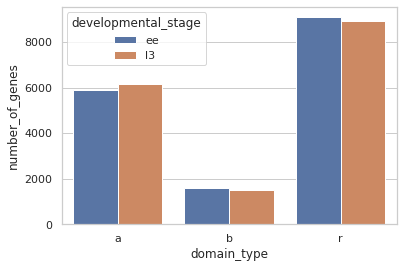

In [15]:
make_plot_for_cutoff_improved(60)

### Make a plot showing the cumulative changes in domain type between ee and l3 at different cutoffs

In [425]:
def how_many_genes_changed(cutoff):
    path='genes_in_domains/genes_in_ee_domains_'+str(cutoff)+'.bed'
    ee_df=pd.read_csv(path, names=all_columns, sep='\t')
    path='genes_in_domains/genes_in_l3_domains_'+str(cutoff)+'.bed'
    l3_df=pd.read_csv(path, names=all_columns, sep='\t')

    regions = [ 'a', 'b', 'r' ]
    stages=['ee','l3']
    
    genehashlist = defaultdict( list )
    
    for i in range(len(ee_df)):
        for r in regions:
            if r in ee_df['chrom_dom_name'][i]:
                genehashlist[ ( r, 'ee') ].append( i )
        
    for i in range(len(l3_df)):
        for r in regions:
            if r in l3_df['chrom_dom_name'][i]:
                genehashlist[ ( r, 'l3') ].append( i )
                
    numbers_dict={}
    for r in regions:
        numbers_dict[r]={}
        for s in stages:
            numbers_dict[r][s]=len(genehashlist[(r,s)])
        
    total_changes=0
    for r in regions:
        value=numbers_dict[r]['l3']-numbers_dict[r]['ee']
        total_changes=total_changes+abs(value)
    
    return(total_changes)

In [427]:
def compare_number_of_changes(cutoffs_list):
    
    y_values=[]
    for cutoff in cutoffs_list:
        y_values.append(how_many_genes_changed(cutoff))

    plotting_df=pd.DataFrame({'cutoffs':cutoffs_list, 'y_values':y_values})
    
    sns.lmplot(x='cutoffs', y='y_values', data=plotting_df, ci=None)

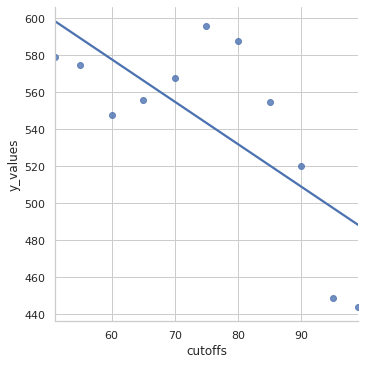

In [439]:
compare_number_of_changes([51,55,60,65,70,75,80,85,90,95,99])

### Look at a few genes that change and see at what cutoff they do so

Go and check a few genes manually. Look at one gene. Extract a few genes that change between stages. See if the trend is a real trend. See where these genes are. See if a gene stays within the domain up until a certain cutoff, and then below that it changes. Don't need to look at what changes to what really. He'd use the most stringest cut-off. You know you have the genes that are a little bit in betwee, a red flag. You can't tell if it's changed to anew domain in c. briggsae.

In [153]:
def changed_genes_per_cutoff(cutoff):
    ee_df=pd.read_csv('genes_in_domains/genes_in_ee_domains_'+str(cutoff)+'.bed', names=all_columns, sep='\t')
    l3_df=pd.read_csv('genes_in_domains/genes_in_l3_domains_'+str(cutoff)+'.bed', names=all_columns, sep='\t')
    moved_genes=[]
    present_genes=[]
    for i in range(len(ee_df[:1000])):
        gene=ee_df['gene_name'][i]
        ee_domain=ee_df['chrom_dom_name'][i][:1]
        l3_row=l3_df[l3_df['gene_name']==gene].reset_index()
        if len(l3_row)>0:
            present_genes.append(gene)
            l3_domain=l3_row['chrom_dom_name'][0]
            if l3_domain[:1] != ee_domain:
                moved_genes.append(gene)
    print((moved_genes[:5]),len(moved_genes))
    

In [155]:
changed_genes_per_cutoff(70)

['WBGene00021677', 'WBGene00004962', 'WBGene00018772', 'WBGene00018958', 'WBGene00000917'] 126


In [156]:
changed_genes_per_cutoff(80)

['WBGene00021677', 'WBGene00004962', 'WBGene00018772', 'WBGene00018958', 'WBGene00021025'] 117


In [157]:
changed_genes_per_cutoff(100)

['WBGene00004962', 'WBGene00018958', 'WBGene00021025', 'WBGene00235388', 'WBGene00022033'] 80


So they show the pattern you'd expect. Progressively lose genes that change domain with each increase in cutoff value. Even though the graph looks weird, it seems mostly okay. This is just looking at genes in domains in both ee and l3.

### Extract all the genes that change from one domain to another between ee and l3

Look specifically at genes that are in domains in both ee and l3, unlike what I did before. Use 100% cutoff. Then do enrichment analysis of these genes using the wormbase tools/enrichment/tea/tea.cgi

In [51]:
ee=pd.read_csv('genes_in_ee_domains_100.bed', names=all_columns, sep='\t')
l3=pd.read_csv('genes_in_l3_domains_100.bed', names=all_columns,sep='\t')

In [52]:
ee

,gene_chrom,gene_chromStart,gene_chromEnd,gene_name,gene_score,gene_strand,gene_thickStart,gene_thickEnd,gene_itemRgb,gene_blockCount,...,gene_blockStart,chrom_dom_chrom,chrom_dom_chromStart,chrom_dom_chromEnd,chrom_dom_name,chrom_dom_score,chrom_dom_strand,chrom_dom_thickStart,chrom_dom_thickEnd,chrom_dom_itemRgb
0,I,4114,10606,WBGene00022277,0,-,4220,10148,0,6,...,"0,1080,1922,5612,5980,6415,",I,3997,54536,a_0,0,0,3997,54536,"0,138,0"
1,I,11494,16837,WBGene00022276,0,+,11640,16585,0,4,...,"0,123,3456,4978,",I,3997,54536,a_0,0,0,3997,54536,"0,138,0"
2,I,17482,26781,WBGene00022278,0,-,17910,26778,0,12,...,"0,523,1532,2788,3365,3530,7168,7446,7790,8888,...",I,3997,54536,a_0,0,0,3997,54536,"0,138,0"
3,I,27588,33150,WBGene00022279,0,-,28279,32482,0,6,...,"0,1511,2180,4180,4823,5448,",I,3997,54536,a_0,0,0,3997,54536,"0,138,0"
4,I,43732,44677,WBGene00022275,0,+,43732,44677,0,5,...,"0,297,548,639,788,",I,3997,54536,a_0,0,0,3997,54536,"0,138,0"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14853,V,20879600,20898909,WBGene00006812,0,+,20879853,20898738,0,34,...,"0,1061,1178,1640,1805,3208,4652,5004,5590,6021...",V,20854830,20923190,r_1040,0,0,20854830,20923190,"0,0,255"
14854,V,20898839,20903535,WBGene00000139,0,-,20898969,20903441,0,6,...,"0,323,1678,2188,2456,4599,",V,20854830,20923190,r_1040,0,0,20854830,20923190,"0,0,255"
14855,V,20903976,20907433,WBGene00009106,0,+,20904174,20907333,0,7,...,"0,351,719,1010,1232,1664,3166,",V,20854830,20923190,r_1040,0,0,20854830,20923190,"0,0,255"
14856,V,20910466,20914387,WBGene00044187,0,+,20910531,20914387,0,9,...,"0,184,918,2080,2216,3019,3245,3403,3889,",V,20854830,20923190,r_1040,0,0,20854830,20923190,"0,0,255"


In [53]:
l3_genes=set(l3['gene_name'])

In [54]:
genes_in_both=[]

for index, row in ee.iterrows():
    if row['gene_name'] in l3_genes:
        genes_in_both.append(row['gene_name'])

In [56]:
changing_genes=[]
strange_ee=[]
strange_l3=[]

for gene in genes_in_both:
    
    ee_row=ee[ee['gene_name']==gene].copy().reset_index()
    if len(ee_row)!=1:strange_ee.append(gene) 
    l3_row=l3[l3['gene_name']==gene].copy().reset_index()
    if len(l3_row)!=1: strange_l3.append(gene)
        
    ee_dom_type=ee_row['chrom_dom_name'][0][:2]
    l3_dom_type=l3_row['chrom_dom_name'][0][:2]
    if ee_dom_type != l3_dom_type: changing_genes.append(gene)

In [57]:
len(genes_in_both)

13488

In [58]:
len(changing_genes)

1135

In [60]:
changed_genes=pd.DataFrame({'gene_name':changing_genes})
changed_genes.to_csv('changed_domain_genes.txt', header=None, index=None, sep='\n')

In [64]:
bkg_genes=pd.DataFrame({'gene_name':genes_in_both})
bkg_genes.to_csv('background_genes.txt', header=None, index=None, sep='\n')

### Input these genes into enrichment analysis

https://wormbase.org/tools/enrichment/tea/tea.cgi

Uploaded changed_domain_genes.txt and background_genes.txt

Downloaded results to 'genes_in_domains/changed_domain_gene_characteristics/'

# Scrap

In [182]:
all_genes=[]
domain_type_in_ee=[]
domain_type_in_l3=[]

for gene in genes_file['name'][:1000]:
    all_genes.append(str(gene))
    
    if gene in list(ee_df['gene_name']):
        row_in_ee=ee_df[ee_df['gene_name']==gene]
        if 'a' in str(row_in_ee['chrom_dom_name']): domain_type_in_ee.append('active')
        elif 'b' in str(row_in_ee['chrom_dom_name']): domain_type_in_ee.append('border')
        elif 'r' in str(row_in_ee['chrom_dom_name']): domain_type_in_ee.append('regulated')
    else: domain_type_in_ee.append('None')

    if gene in list(l3_df['gene_name']):
        row_in_l3=l3_df[l3_df['gene_name']==gene]
        if 'a' in str(row_in_l3['chrom_dom_name']): domain_type_in_l3.append('active')
        elif 'b' in str(row_in_l3['chrom_dom_name']): domain_type_in_l3.append('border')
        elif 'r' in str(row_in_l3['chrom_dom_name']): domain_type_in_l3.append('regulated')
    else: domain_type_in_l3.append('None')
        
#20 genes seem to be in 2 domains, so these results aren't completely accurate because I'm using elif. But wasn't sure how to deal with it otherwise

In [183]:
len(all_genes)

1000

In [184]:
len(domain_type_in_ee)

1000

In [186]:
genes_in_domains=pd.DataFrame({'gene':all_genes, 'ee_domain':domain_type_in_ee, 'l3_domain':domain_type_in_l3})

In [189]:
genes_in_domains[genes_in_domains['l3_domain']=='border']

,gene,ee_domain,l3_domain


In [185]:
len(ee_df)

67621

In [161]:
len(genes_file)

71100

In [157]:
genes_in_domains=pd.DataFrame({'gene':all_genes, 'ee_domain':domain_type_in_ee, 'l3_domain':domain_type_in_l3})

In [158]:
active=genes_in_domains[genes_in_domains['l3_domain']=='active']

In [159]:
len(active)

0

In [129]:
genes_in_domains_good

,gene,ee_domain,l3_domain
0,MTCE.1,None,None
1,MTCE.2,None,None
2,MTCE.3.1,None,None
3,MTCE.4.1,None,None
4,MTCE.5,None,None
...,...,...,...
71095,2RSSE.1c.1,None,None
71096,2RSSE.6,None,None
71097,2RSSE.3,None,None
71098,2RSSE.5,None,None


In [ ]:
def find_number()

In [ ]:
outcomehash=dict()
for stage in ['ee','l3']:
    if stage='ee':df=ee_df
    if stage='l3':df=l3_df
    outcomehash[stage]=dict()
    for region_type in ['a','b','r']:
        outcomehash[stage][region_type]=dict()
        outcomehash[stage][region_type]['gene_number']=df
    

In [84]:
ee_a_genes_df=ee_df.iloc[a_genes_ee,:]